   # <font color='FF3300'>Visualisation des résultats des calculs du projet précédent.

Dans ce tutoriel on reprend Tutoriel_API_Code_TYMPAN-1.
On visualise pour chaque récépteurs l'influence de toutes les sources sur ce récépteur.
#### On suivra les étapes
* Initialisation
* Récupération du projet xml
* Calcul de l'influence par récépteur
* Visualisation du résultat

BACHIR : pour ce tutorial, rajouter peut-être une phrase au début pour dire qu'on simule un résiduel et qu'on l'utilise avec un calcul tympan pour calculer l'emergence

### <font color='FF3300'>Initialisation</font>

On importe les différentes parties propres à TYMPAN le <font color='9900CC'>Projet</font>, le <font color='9900CC'>Site</font>, le <font color='9900CC'>Model</font> et le <font color='9900CC'>Solver</font> mais aussi les outils comme Point3D, Spectrum, Source

In [2]:
from tympan.models.project import Project 
from tympan.models.solver import Spectrum, Model, Solver, Source
from tympan.models._common import Point3D

On importe des bibliothèques nécéssaires à la visualisation ou aux objet que l'on utilise

In [2]:
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.colors as colors
from pylab import cm,imshow, show, figure
chemin_proj = r'Mon_projet.xml'

In [3]:
def resultat(my_project):
    """depuis un projet calcul le resultat le sauvegarde dans le projet et le renvoie """
    my_model = Model.from_project(my_project)
    my_solver = Solver.from_project(my_project,verbose=True)
    my_result = my_solver.solve(my_model)
    my_project.import_result(my_model,my_result)
    return my_result

On définit une fonction ajout bruit permettant de donner un spectre aux sources du projet qui ne font pas de bruit.
Si aucun spectre n'est spécifié, un spectre est donné par défaut

### <font color='FF3300'>Récupération du projet</font>

In [ ]:
my_project = Project.from_xml(chemin_proj, verbose=True)
my_model = Model.from_project(my_project)

In [ ]:
for source in my_project.site.user_sources:
    source.set_spectrum(Spectrum(np.array([90]*31),dtype=float))

In [5]:
my_solver = Solver.from_project(my_project,verbose=True)
my_result = my_solver.solve(my_model)

D:\Tympan_exe\TYMPAN_exe\cython_d\tympan\altimetry\builder.py:71: RuntimeWarning: main site landtake (or surrounding level curve) does not appear to be closed; closing it for altimetry processing
  RuntimeWarning)


### <font color='FF3300'>Calcul de l'influence par récépteur</font>
Pour chacun des récépteurs du projet on somme le spectre des sources et on affiche les histogrammes de ces résultats
* ```python
my_result.nreceptors #Donne le nombre de récépteurs du résultat 
my_result.nsources #Donne le nombre de sources du résultat```


In [7]:
res_rec = []
for id_rec in range(my_result.nreceptors):
    tab_rec = np.zeros(31,)
    for id_src in range(my_result.nsources):
        tab_rec += my_result.spectrum(id_rec,id_src).values
    res_rec.append(10*np.log10(tab_rec/4e-10))

### <font color='FF3300'> Visualisation du résultat</font>
On a récupérer le résultat par récépteur dans ```res_rec```. On fait alors un diagramme en barres des valeurs du spectre des récépteurs

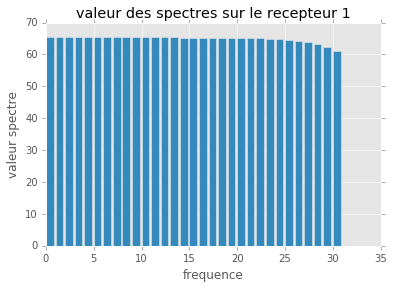

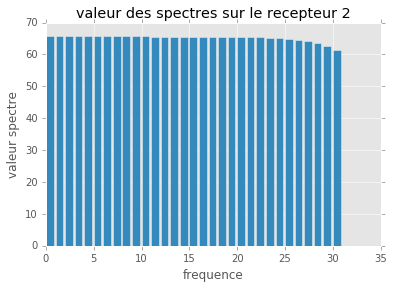

In [8]:
for i, res in enumerate(res_rec):
    plt.figure()
    plt.title("valeur des spectres sur le recepteur {}".format(i))
    plt.xlabel("frequence")
    plt.ylabel("valeur spectre")
    plt.bar(range(31),res)
plt.show()

# <font color='FF3300'> Calcul avec un récépteur surfacique </font>

On a ajouter au projet précédent un récépteur surfacique à traver l'IHM, on a aussi ajouté un nouveau calcul dans lequel on a supprimer une des sources.
#### On suivra les étapes
* Récupération du projet.
* Calcul de l'influence de l'émergence
* Visualisation

### <font color='FF3300'>Récupération du projet</font>
* ```python
res #correspond au resultat du solver ```

In [9]:
my_project = Project.from_xml(r'Mon_proj_arec.xml', verbose=True)
my_model = Model.from_project(my_project)
my_solver = Solver.from_project(my_project, verbose=True)
res = my_solver.solve(my_model)

D:\Tympan_exe\TYMPAN_exe\cython_d\tympan\altimetry\builder.py:71: RuntimeWarning: main site landtake (or surrounding level curve) does not appear to be closed; closing it for altimetry processing
  RuntimeWarning)


### <font color='FF3300'> Calcul de l'émergence</font>
Pour chacun des résultat, pour chacun des récépteurs on ajoute les spectres des sources. 
* ```python
resu.nreceptors #donne le nombre de récépteurs dans ce résultat```
* ```python
resu.nsources #donne le nombre de sources dans ce résultat```
* ```python 
id_r,id_s #sont les indices des sources et récépteurs considérés.```
* ```python
resu.spectrum(id_r,id_s) #donne le spectre de la source id_s sur le recepteur id_r sous la forme d'un objet Spectrum
resu.spectrum(id_r,id_s).values #donnes le spectre de la source id_s sur le recepteur id_r sous la forme d'un objet numpy.array```
* ```python
influences #est une liste de deux éléments, chaque élément est un numpy array contenant pour chaque récépteur la somme des valeurs des spectres des sources.```
* ```python 
diff_carto #contient l'émergence calculé comme la somme log de la carto calculé et de la carto mesurée à laquelle on soustrait la carto mesurée```
* ```python
X et Y correspondent aux listes des abscisses et ordonnées des récépteurs de la carto ``` 

In [10]:
influences = []
from sklearn.gaussian_process import GaussianProcess
#from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

#On crée une carto(ici la carto vient d'une mesure)
## Observation a la main
xv=[1.,7.,3.,5.,6.,9.,-14.]
yv=[2.,2.5,7.,9.,0.,1.75,12.]
obs=[24,16,22,31,19,18,55.]

XX= np.atleast_2d([xv,yv]).T
YY=np.atleast_2d([obs]).T

## Prediction par une estimateur de "Krigeage" > Scikitlearn l'appelle "Gaussian Process"
#kernel = C(30.0, (1e-3, 1e3)) * RBF(10., (1e-2, 1e2))
gp = GaussianProcess()
gp.fit(XX, YY)

x2fit=np.linspace(-10., 10., len(list(set([rec.position.x for rec in my_model.receptors]))))
y2fit=np.linspace(-10., 10., len(list(set([rec.position.y for rec in my_model.receptors]))))

x_fullgrid, y_fullgrid = np.meshgrid(x2fit, y2fit)

xfv=np.reshape(x_fullgrid,-1)
yfv=np.reshape(y_fullgrid,-1)
XF= np.atleast_2d([xfv,yfv]).T
y_pred, sigma = gp.predict(XF,eval_MSE=True)

resultat=np.reshape(y_pred,-1)

influences.append(resultat)

In [11]:
#On récupère pour chaque recepteur l'influence des source en fonction de la fréquence
l = []
for id_r in range(my_model.nreceptors):
    tab_rec = np.zeros(31,)
    for id_s in range(my_model.nsources):
        tab_rec += res.spectrum(id_r,id_s).values
    l.append(Spectrum(10*np.log10(tab_rec/4e-10)).to_dB().dBA)
influences.append(np.array(l))

#On calcule l'emergence et l'on stocke dans diff_carto
diff_carto = [10*np.log10(10**(l1/10)+10**(l2/10)) for l1,l2 in zip(influences[0],influences[1])]
diff_carto -= influences[0]

X = [rec.position.x for rec in my_model.receptors]
Y = [rec.position.y for rec in my_model.receptors]

### <font color=FF3300>Visualisation</font>
On boucle ensuite sur tout les récépteurs et on fait de l'affichage
* ```python
plt.figure() #Créer une nouvelle fenetre d'affichage```
* ```python
axx = list(set(X))
axx.sort()
axy = list(set(Y))
axy.sort() #On crée les liste sans doublons ordonées correspondant aux abscisses et ordonnées des récépteurs ```
* ```python
taille = np.meshgrid(axx,axy)[1].shape
effet_source = np.resize(effet_source,taille) #On redimenssionne la liste effet_source pour en faire une matrice de la meme taille que axx*axy ```
* ```python
plt.xticks(range(0,len(X),4),axx[::4])
plt.yticks(range(0,len(Y),4),axy[::-4]) #On définit les axes```
* ```python
plt.imshow(effet_source,cmap=cm.virdis) #On crée le dessin avec la colormap RdBu```
* ```python
plt.show() #On affiche les histogrammes```
[tutoriel de matplotlib](https://matplotlib.org/users/index.html)

In [1]:
#On dessine la représentation de l'influence de la source sur le récépteur surfacique
fig = figure(figsize=(10,20))
axx = list(set(X))
axx.sort()
axy = list(set(Y))
axy.sort()
taille = np.meshgrid(axx,axy)[1].shape
diff_carto = np.resize(diff_carto,taille)
plt.contour(diff_carto,20,colors='black')
plt.xticks(range(0,len(X),4),axx[::4])
plt.yticks(range(0,len(Y),4),axy[::-4])
plt.imshow(diff_carto)
plt.colorbar()
plt.show()

NameError: name 'figure' is not defined

Il existe un script ```ope_rec_surf.py``` prenant en entrée un projet tympan et qui permet de calculer pour un récépteur surfacique l'émergence, le bruit ambiant où la différence entre deux calculs différents.
Le résultat est sauvegarder comme résultat du calcul